In [190]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [204]:
# Download historical stock price data for Apple
ticker = "AAPL"
start_date = "2012-12-12"
end_date = "2022-12-12"
apple_data = yf.download(ticker, start=start_date, end=end_date)

mses = np.array([])
# Extract the features (last N days of closing prices) and target (current day's closing price)
features = pd.DataFrame(index=apple_data.index)
lower_end_minus_one = 6
for j in range(lower_end_minus_one,100):
  for i in range(1, j):
      #each column name refers to the lagged closing price
      colname = f"Close-{i}"
      features[colname] = apple_data["Close"].shift(i)
  target = apple_data["Close"]

  # Split the data into training and testing sets
  train_features = features.loc[:'2022-01-01']
  train_target = target.loc[:'2022-01-01']
  test_features = features.loc['2022-01-02':]
  test_target = target.loc['2022-01-02':]

  #get rid of NA values as a result of shifting
  train_features = train_features.dropna()
  train_features.columns = [f"Close-{i}" for i in range(1, j)]
  train_target = train_target.dropna()
  train_target = train_target[j-1:]
  
  #Updated Ridge Regression with parameters from GridSearchCV below
  model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'svd', tol= 0.001)
  model.fit(train_features.values, train_target)

  # Make predictions for the test set recursively
  predictions = []
  #initialize the last N days array with the last portion of the training data
  last_N_days = train_features.tail(j-1)


  for i in range(len(test_target)):
      prediction = model.predict(last_N_days.T)
      predictions.append(prediction[0])
      last_N_days = last_N_days.shift(-1)
      last_N_days.iloc[-1] = prediction

  # calculate the MSE
  mse = mean_squared_error(test_target, predictions)
  #add this MSE to the list of MSEs
  mses = np.append(mses, mse)
  
  #predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])

#find the minimum MSE and the corresponding index (number of days used as features) it occurs at
print(min(mses), np.argmin(mses)) 

[*********************100%***********************]  1 of 1 completed
182.1277611565235 80


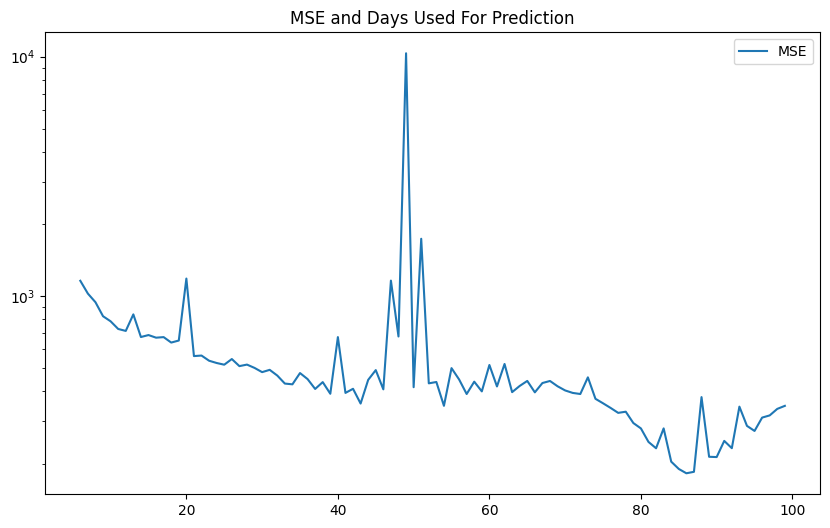

In [205]:
#Plot the MSE in relation to the number of days used
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(lower_end_minus_one,100), y=mses, label='MSE', ax=ax)
plt.yscale("log")
plt.title('MSE and Days Used For Prediction')
plt.show()

In [225]:
#starting with Apple, retrain the model so that it uses the number of 
#days as features which gives the lowest MSE
ticker = "AAPL"
start_date = "2012-12-12"
end_date = "2022-12-12"
apple_data = yf.download(ticker, start=start_date, end=end_date)


# Extract the features (last 85 days of closing prices) and target (current day's closing price)
features = pd.DataFrame(index=apple_data.index)
for i in range(1, lower_end_minus_one+np.argmin(mses)):
  colname = f"Close-{i}"
  features[colname] = apple_data["Close"].shift(i)
target = apple_data["Close"]

# Split the data into training and testing sets
train_features = features.loc[:'2022-01-01']
train_target = target.loc[:'2022-01-01']
test_features = features.loc['2022-01-02':]
test_target = target.loc['2022-01-02':]

train_features = train_features.dropna()
train_features.columns = [f"Close-{i}" for i in range(1, lower_end_minus_one+np.argmin(mses))]
train_target = train_target.dropna()
train_target = train_target[lower_end_minus_one+np.argmin(mses)-1:]

#Updated Ridge Regression with parameters from GridSearchCV below
model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'svd', tol= 0.001)
model.fit(train_features.values, train_target)

# Make predictions for the test set using the recursive approach
predictions = []
last_N_days = train_features.tail(np.argmin(mses)+lower_end_minus_one-1)
for i in range(len(test_target)):
    prediction = model.predict(last_N_days.T)
    predictions.append(prediction[0])
    last_N_days = last_N_days.shift(-1)
    last_N_days.iloc[-1] = prediction


predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])
print(predictions_df)
print(test_target)

[*********************100%***********************]  1 of 1 completed
             Predicted
Date                  
2022-01-03  175.258803
2022-01-04  179.365561
2022-01-05  175.192435
2022-01-06  175.659603
2022-01-07  178.549827
...                ...
2022-12-05  177.519732
2022-12-06  179.624368
2022-12-07  182.787981
2022-12-08  184.723602
2022-12-09  184.222992

[237 rows x 1 columns]
Date
2022-01-03    182.009995
2022-01-04    179.699997
2022-01-05    174.919998
2022-01-06    172.000000
2022-01-07    172.169998
                 ...    
2022-12-05    146.630005
2022-12-06    142.910004
2022-12-07    140.940002
2022-12-08    142.649994
2022-12-09    142.160004
Name: Close, Length: 237, dtype: float64


In [106]:
#Hyper-Parameter Tuning with GridSearchCV
#ran and updated the model above with new parameters

# create a Ridge regression model
model = Ridge()

# lists the parameters to test
params = {
    'fit_intercept': [True, False],
    'alpha': [0.1, 1.0, 10.0],
    'tol': [0.001, 0.0001],
    'max_iter': [1000, 5000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# create a GridSearchCV object with 5-fold cross-validation
grid = GridSearchCV(model, params, cv=5)


# fit the GridSearchCV object to the data
grid.fit(train_features.values, train_target)

# print the best hyperparameters and score
print("Best hyperparameters:", grid.best_params_)
print("Score:", grid.score(train_features.values, train_target))

Best hyperparameters: {'alpha': 1.0, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'svd', 'tol': 0.001}
Test score: 0.9995290185561269


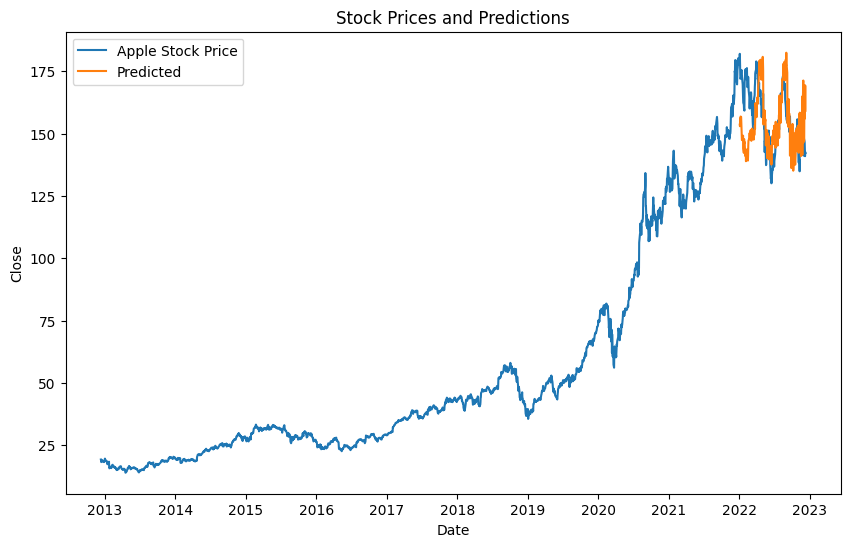

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=apple_data, x=apple_data.index, y='Close', label='Apple Stock Price', ax=ax)
sns.lineplot(data = predictions_df, x=predictions_df.index, y='Predicted', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

In [213]:
restOfFAANG = ['AMZN', 'GOOG', 'META', 'NFLX']
daysToUse = []
for ticker in restOfFAANG:
  start_date = "2012-12-12"
  end_date = "2022-12-12"
  company_data = yf.download(ticker, start=start_date, end=end_date)

  mses = np.array([])
  # Extract the features (last 5 days of closing prices) and target (current day's closing price)
  features = pd.DataFrame(index=company_data.index)
  lower_end_minus_one = 6
  for j in range(lower_end_minus_one,100):
    for i in range(1, j):
        colname = f"Close-{i}"
        features[colname] = company_data["Close"].shift(i)
    target = company_data["Close"]

    # Split the data into training and testing sets
    train_features = features.loc[:'2022-01-01']
    train_target = target.loc[:'2022-01-01']
    test_features = features.loc['2022-01-02':]
    test_target = target.loc['2022-01-02':]
    
    train_features = train_features.dropna()
    train_features.columns = [f"Close-{i}" for i in range(1, j)]
    train_target = train_target.dropna()
    train_target = train_target[j-1:]
    
    model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'svd', tol= 0.001)
    model.fit(train_features.values, train_target)

  # Make predictions for the test set using the recursive approach
    predictions = []
    last_N_days = train_features.tail(j-1)
    for i in range(len(test_target)):
        prediction = model.predict(last_N_days.T)
        predictions.append(prediction[0])
        last_N_days = last_N_days.shift(-1)
        last_N_days.iloc[-1] = prediction

    # Calculate the MSE
    mse  = mean_squared_error(test_target, predictions)
    # Add the MSE to the list of MSEs
    mses = np.append(mses, mse)
    predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])
    
  #Print the current lowest MSE for this ticker and the index it occurs at
  print(min(mses), np.argmin(mses)) 
  #Add the index to daysToUse
  daysToUse.append(np.argmin(mses))

[*********************100%***********************]  1 of 1 completed
2241.4023814435727 89
[*********************100%***********************]  1 of 1 completed
958.2174866555752 89
[*********************100%***********************]  1 of 1 completed
25227.47317811996 17
[*********************100%***********************]  1 of 1 completed
116073.25332839559 10


In [209]:
#redeclare array in case above block has been ran multiple times
#which would give it an array size > 5
daysToUse = [80,89,89,17,10]

# Define the tickers of the stocks to download
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'NFLX']
data = yf.download(tickers, start='2012-12-12', end='2022-12-12')['Close']

data_lagged = pd.DataFrame(index=data.index)
for index,ticker in enumerate(tickers):
  for i in range(0, lower_end_minus_one+daysToUse[index]):
    colname = f"{ticker}Close-{i}"
    data_lagged[colname] = data[ticker].shift(i)
data_lagged = data_lagged.dropna()

[*********************100%***********************]  5 of 5 completed


In [226]:

# Split the data into training and testing sets
train_data = data_lagged.iloc[:-30]
test_data = data_lagged.iloc[-30:]

# Fit a linear regression model to the training data for each stock
models = {}
for ticker in tickers:
    X_train = train_data.iloc[:, :-5].values
    X_test = test_data.iloc[:, :-5].values
    y_train = train_data[f'{ticker}Close-0'].values
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[ticker] = model

# Make predictions on the testing data
predFAANG = []
last_N_days = train_data.iloc[-1, :-5]

for i in range(len(test_data)):
    X_test_i = np.concatenate([models[ticker].predict(last_N_days.values.flatten().reshape(1, -1)) for ticker in tickers])
    predFAANG.append(X_test_i)
    last_N_days = pd.concat([last_N_days.iloc[5:], pd.DataFrame(X_test_i[:])])
    

# Create a dataframe with the predicted values
predFAANG_df = pd.DataFrame(predFAANG, columns=tickers, index=test_data.index)


# Calculate the MSE for each company's stock price
mse_values = {}
for ticker in tickers:
    y_test = test_data[f'{ticker}Close-0'].values
    y_pred = predFAANG_df[ticker].values
    mse = mean_squared_error(y_test, y_pred)
    mse_values[ticker] = mse

# Print the MSE values for each company
print(mse_values)

            AAPLClose-0  AAPLClose-1  AAPLClose-2  AAPLClose-3  AAPLClose-4  \
Date                                                                          
2022-10-21   147.270004   143.389999   143.860001   143.750000   142.410004   
2022-10-24   149.449997   147.270004   143.389999   143.860001   143.750000   
2022-10-25   152.339996   149.449997   147.270004   143.389999   143.860001   
2022-10-26   149.350006   152.339996   149.449997   147.270004   143.389999   
2022-10-27   144.800003   149.350006   152.339996   149.449997   147.270004   

            AAPLClose-5  AAPLClose-6  AAPLClose-7  AAPLClose-8  AAPLClose-9  \
Date                                                                          
2022-10-21   138.380005   142.990005   138.339996   138.979996   140.419998   
2022-10-24   142.410004   138.380005   142.990005   138.339996   138.979996   
2022-10-25   143.750000   142.410004   138.380005   142.990005   138.339996   
2022-10-26   143.860001   143.750000   142.410004  

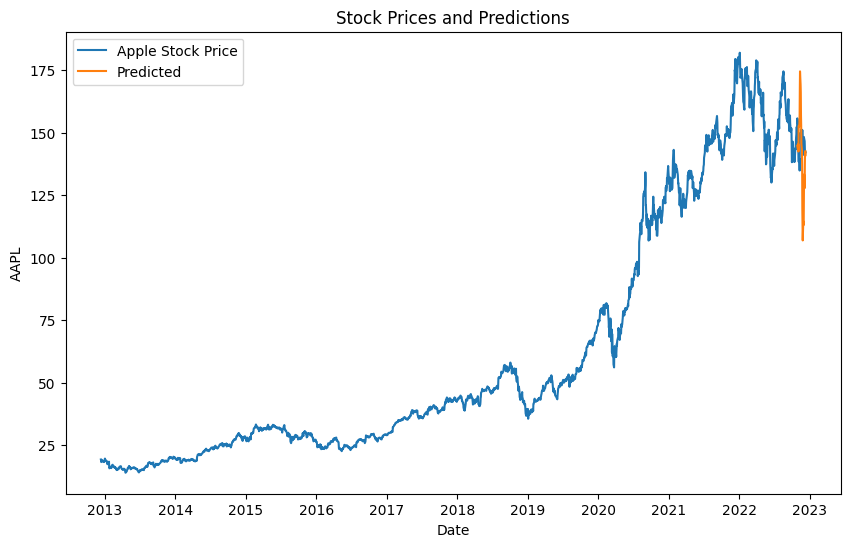

In [198]:
#Predicted Apple Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['AAPL'], label='Apple Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='AAPL', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

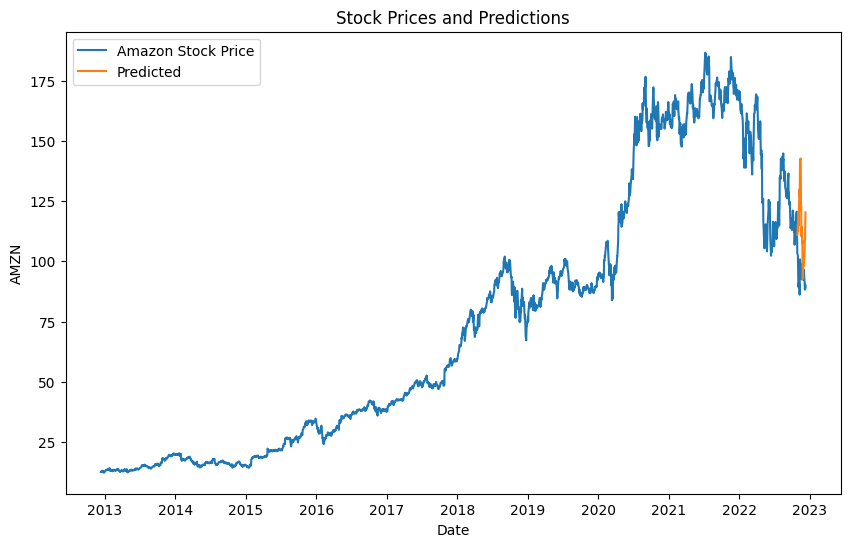

In [199]:
#Predicted Amazon Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['AMZN'], label='Amazon Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='AMZN', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

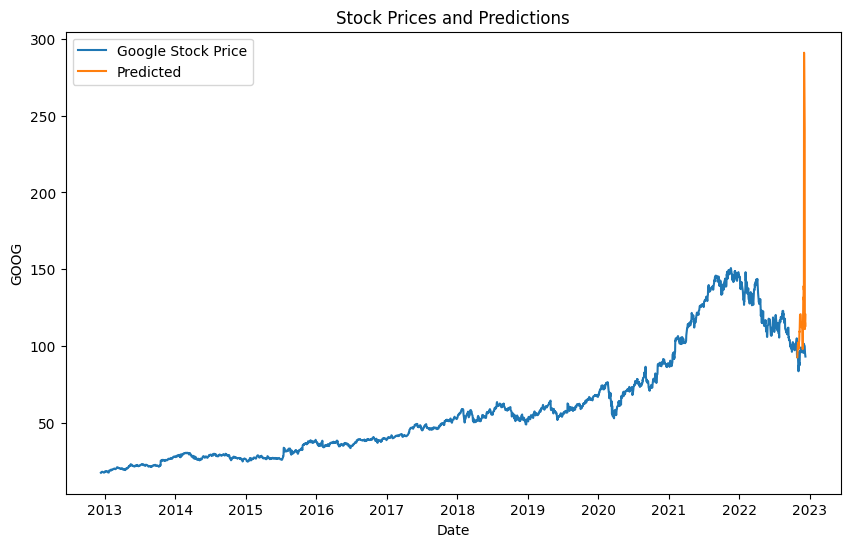

In [200]:
#Predicted Google Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['GOOG'], label='Google Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='GOOG', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

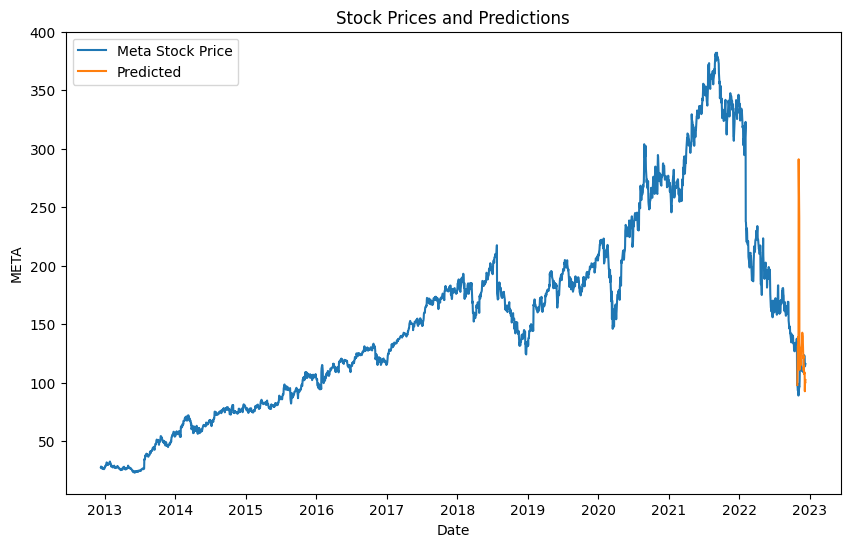

In [201]:
#Predicted META Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['META'], label='Meta Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='META', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

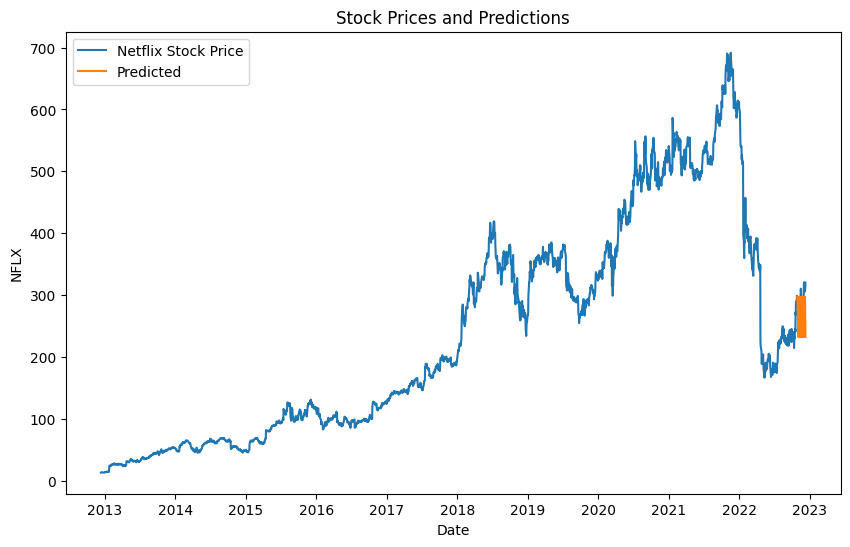

In [202]:
#Predicted Netflix Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['NFLX'], label='Netflix Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='NFLX', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()